<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative06102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações das Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

Verificando as versões do Tensorflow e keras

In [ ]:
print(tf.__version__)

# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

2.6.0


In [ ]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# **###  Download dos dados / descompactando os dados**

In [ ]:
#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity    

geological-image-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)


# ** Criação da estrutura e leitura de diretórios **

In [ ]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))


5000
5000
4998
5000
5000
5000


In [ ]:
andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)

29998

In [ ]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/andesite/IF95P.jpg,andesite
1,geological_similarity/andesite/X3O1H.jpg,andesite
2,geological_similarity/quartzite/278VW.jpg,quartzite
3,geological_similarity/schist/6ZDIH.jpg,schist
4,geological_similarity/marble/5H9NG.jpg,marble
...,...,...
29993,geological_similarity/rhyolite/3WHTU.jpg,rhyolite
29994,geological_similarity/schist/7S870.jpg,schist
29995,geological_similarity/quartzite/32KN8.jpg,quartzite
29996,geological_similarity/andesite/7HV1M.jpg,andesite


In [ ]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


In [ ]:
# Converter os dados e rótulos em matrizes NumPy enquanto dimensiona o pixel, intensidades na faixa [0, 255]

dados = np.array(dados) 
labels = np.array(labels)
labels

array(['andesite', 'andesite', 'quartzite', ..., 'quartzite', 'andesite',
       'rhyolite'], dtype='<U9')

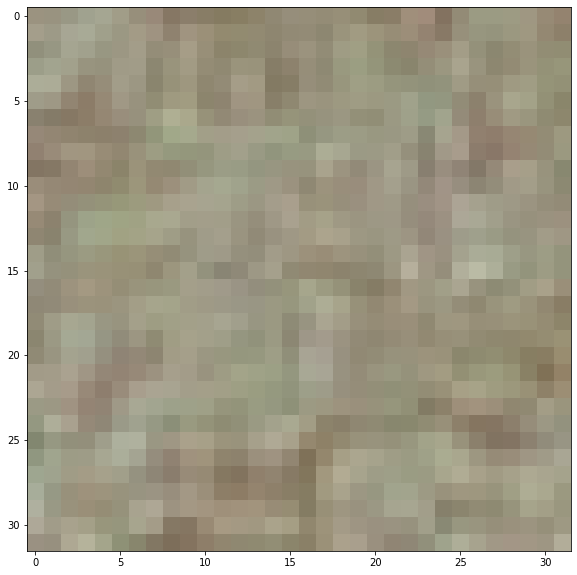

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

In [ ]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)



[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]]


In [ ]:
# executa codificação one-hot nas tags

#lb = LabelBinarizer()
#labels2 = lb.fit_transform(labels)
#labels2 = to_categorical(labels2)
#labels2
#type(labels2)

numpy.ndarray

# **Criando o Dataframe em dados de treino, validação e teste**

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


## Normalização  

In [ ]:
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 3).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 28, 28, 3).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 3).astype('float32')

X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

#  Conhecendo os dados de imagem

In [ ]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

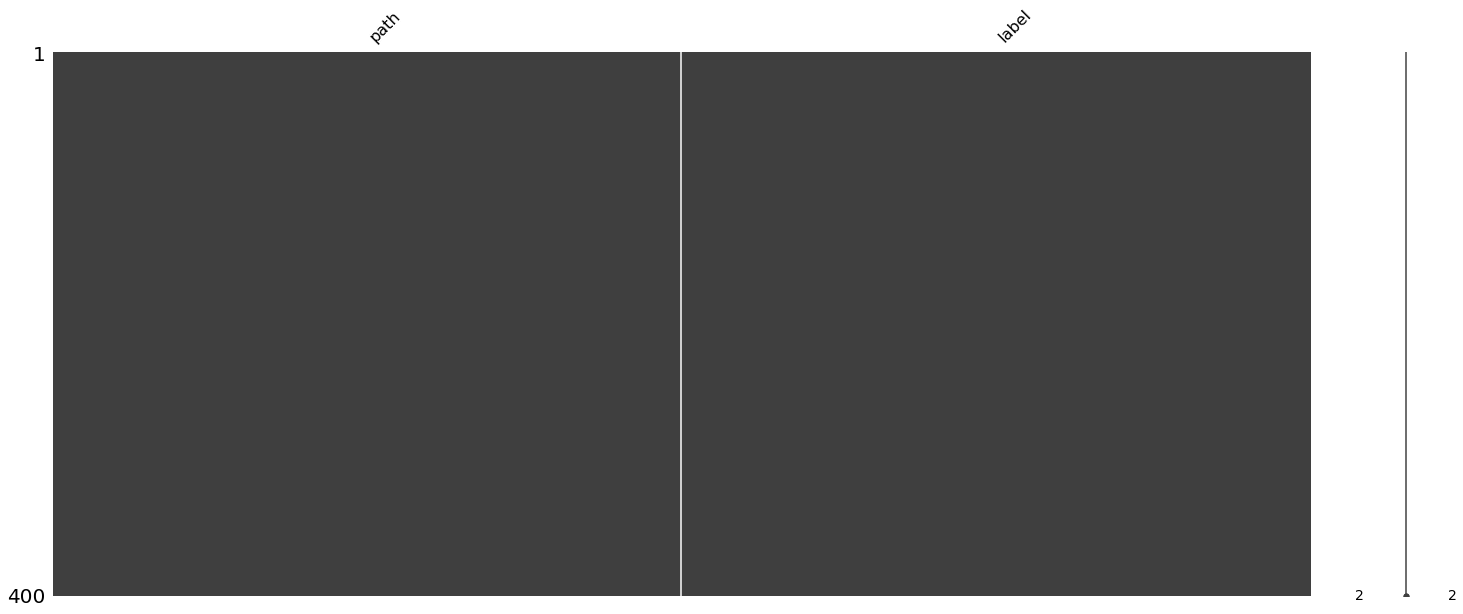

In [ ]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

In [ ]:
#! pip install pandas-profiling==2.8.0
#from pandas_profiling import ProfileReport
#ProfileReport (data_df)

# ***Criação dos Parâmetros***

In [ ]:
INIT_LR = 1e-3
EPOCHS = 100
BS=24

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [ ]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# Dados de Treino e Validação

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)


In [ ]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [ ]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation') 


 

Found 29998 validated image filenames belonging to 6 classes.


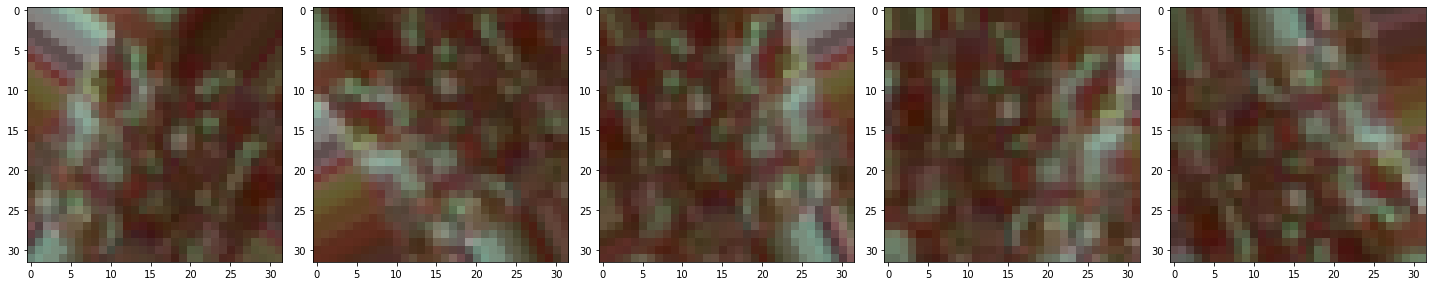

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

train_generator.class_indices.keys()

{'andesite': 0,
 'gneiss': 1,
 'marble': 2,
 'quartzite': 3,
 'rhyolite': 4,
 'schist': 5}

In [ ]:
X_test, y_test = next(test_generator)
print(X_test.shape)
print(y_test.shape)

(24000, 32, 32, 3)
(24000, 6)


# **Criar o modelo**

In [ ]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])

# **Compilando o Modelo**

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 16)          0

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# **Avaliar o modelo**

In [ ]:
history = model.fit(X_train,y_train,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callbacks_list,
                               steps_per_epoch = len(X_train)//BS, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_steps = len(X_val)//BS,
                               validation_data= (X_val,y_val))

Epoch 1/100
749/749 [==============================] - 36s 8ms/step - loss: 0.8822 - accuracy: 0.6616 - val_loss: 0.3581 - val_accuracy: 0.8930

Epoch 00001: val_accuracy improved from -inf to 0.89300, saving model to best_model.h5
Epoch 2/100
749/749 [==============================] - 6s 8ms/step - loss: 0.3993 - accuracy: 0.8643 - val_loss: 0.2469 - val_accuracy: 0.9165

Epoch 00002: val_accuracy improved from 0.89300 to 0.91650, saving model to best_model.h5
Epoch 3/100
749/749 [==============================] - 6s 8ms/step - loss: 0.2955 - accuracy: 0.9022 - val_loss: 0.1700 - val_accuracy: 0.9443

Epoch 00003: val_accuracy improved from 0.91650 to 0.94433, saving model to best_model.h5
Epoch 4/100
749/749 [==============================] - 7s 9ms/step - loss: 0.2411 - accuracy: 0.9210 - val_loss: 0.1711 - val_accuracy: 0.9378

Epoch 00004: val_accuracy did not improve from 0.94433
Epoch 5/100
749/749 [==============================] - 6s 8ms/step - loss: 0.2146 - accuracy: 0.9303 

**Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.**

Text(0.5, 1.0, 'Train - Accuracy')

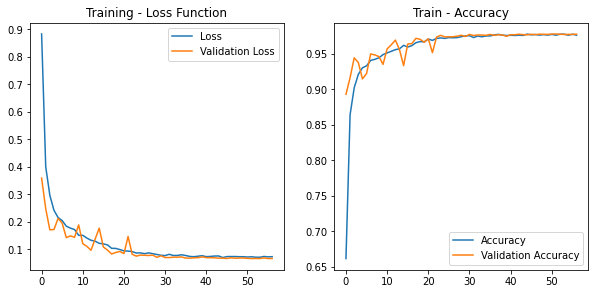

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

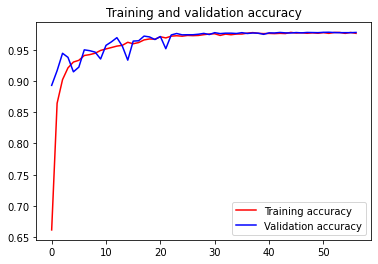

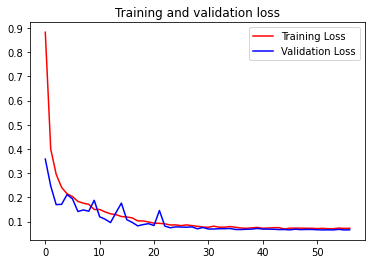

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#history2= model.history.history
#px.line(history2,title = "Metrics Plot")

# **Otimizar o modelo**

In [ ]:
# Aguardando codigo

# **Avaliar acurácia  do Modelo**

In [ ]:
model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))

188/188 [==============================] - 1s 5ms/step - loss: 0.0737 - accuracy: 0.9750
validation_accuracy: 0.9750000238418579


# **Listando as redes realmente disponíveis em seu Keras**

In [ ]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**
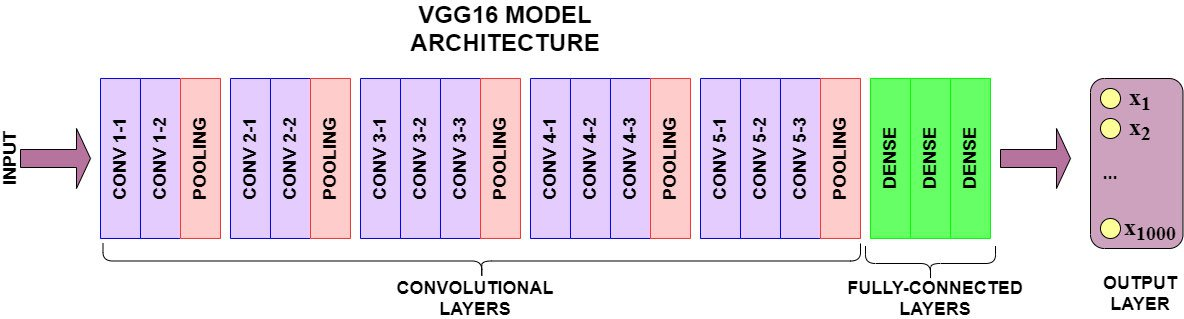

In [ ]:
# Inicializar a CNN
classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Marcar as camadas como não treináveis
#for layer in classifier.layers:
   # layer.trainable = False

for layer in classifier.layers[:-2]:
  layer.trainable = False
  print(layer)

# Criar o novo modelo
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 , offset=-1)
x = scale_layer(inputs)

# Adicionar novas camadas para classificação

x = classifier(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# Definir o modelo
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [ ]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [ ]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

Epoch 1/100
749/749 [==============================] - 22s 28ms/step - loss: 0.4859 - accuracy: 0.8333 - val_loss: 0.2483 - val_accuracy: 0.9148
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 2/100
749/749 [==============================] - 21s 28ms/step - loss: 0.2678 - accuracy: 0.9095 - val_loss: 0.1665 - val_accuracy: 0.9423
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 3/100
749/749 [==============================] - 21s 28ms/step - loss: 0.2166 - accuracy: 0.9261 - val_loss: 0.1562 - val_accuracy: 0.9437
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 4/100
749/749 [==============================] - 21s 28ms/step - loss: 0.1821 - accuracy: 0.9381 - val_loss: 0.1477 - val_accuracy: 0.9450
INFO:tensorflow:Assets written to: feature_extraction.vgg16/assets
Epoch 5/100
749/749 [==============================] - 20s 26ms/step - loss: 0.1646 - accuracy: 0.9447 - val_loss: 0.1396 - val_accuracy: 0.9507
INFO:te

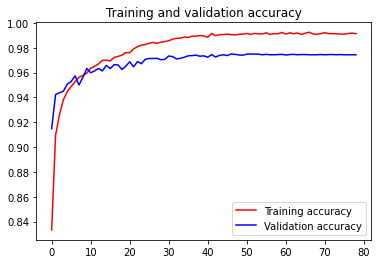

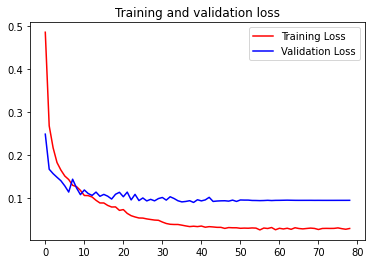

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

188/188 [==============================] - 5s 21ms/step - loss: 0.0902 - accuracy: 0.9743
validation_accuracy: 0.9743333458900452


# **Realizar a Predição para as 6 classes**

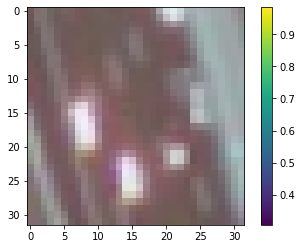

In [55]:
plt.figure()
plt.imshow(X_train[10])
plt.colorbar()
plt.grid(False)
plt.show()

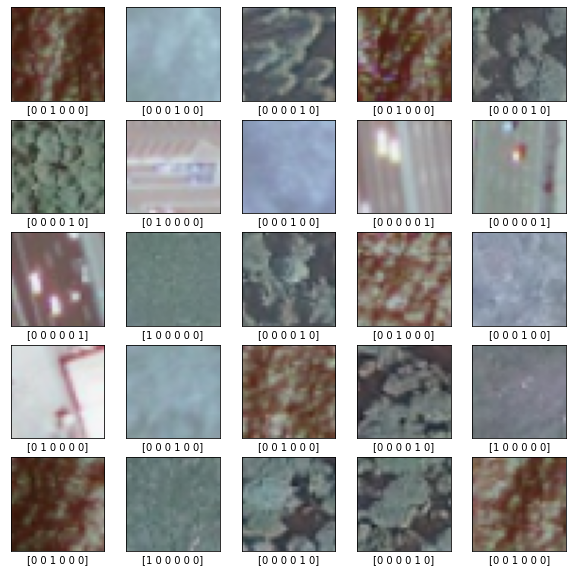

In [58]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

'''plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])
plt.show()'''

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
   

In [59]:
y_pred = model.predict(X_test)
print("Prediction_accuracy: " + str(y_pred))

Prediction_accuracy: [[9.90467012e-01 1.70777173e-06 1.58901457e-07 9.13976226e-03
  3.17996397e-04 7.34413188e-05]
 [6.90715467e-08 1.21450751e-06 4.82169282e-09 6.24060988e-07
  7.75977005e-10 9.99998093e-01]
 [1.57776376e-05 4.46305251e-07 8.14248136e-09 9.99979258e-01
  2.01302370e-07 4.34558387e-06]
 ...
 [5.30467776e-04 6.17322166e-06 4.77806346e-08 9.99445140e-01
  1.94066820e-06 1.62312208e-05]
 [5.83935446e-07 1.90767911e-04 2.83529644e-08 4.88929663e-06
  1.41385570e-09 9.99803722e-01]
 [7.65479856e-13 1.25047417e-10 1.00000000e+00 4.21525835e-12
  1.07697025e-08 3.96622769e-11]]


In [66]:
y_pred[5000] # primeira predição

array([1.5582825e-09, 5.2835105e-07, 9.9999869e-01, 8.3161238e-09,
       1.8538184e-07, 6.9826928e-07], dtype=float32)

In [69]:
np.argmax(y_pred[5000])

2

In [71]:
y_test [5000]

array([0, 0, 1, 0, 0, 0])

# **Matriz de Confusão**

In [ ]:
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

y_pred = model.predict(X_test,batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)


confusion_matrix(y_test.argmax(axis=1),y_pred)



array([[834,   0,   3,  46, 103,  14],
       [  0, 894,   6,   2,   0,  98],
       [  0,   1, 999,   0,   0,   0],
       [ 43,   2,   0, 945,   4,   6],
       [ 53,   0,   0,   0, 946,   1],
       [  1,  88,  18,   2,  10, 881]])

In [ ]:
'''mapping ={0:'andesite',1:'gneiss',2:'marbler',3:'quartzite',4:'rhyolite',5:'schist'}

fig,ax=plt.subplots(figsize=(6,6))

cm_viz =ConfusionMatrix(
                          model,
                          classes = ['andesite','gneiss','marbler','quartzite','rhyolite','schist'],
                          #label_encoder=mapping,
                          )
#cm_viz.score(X_test,y_test)'''

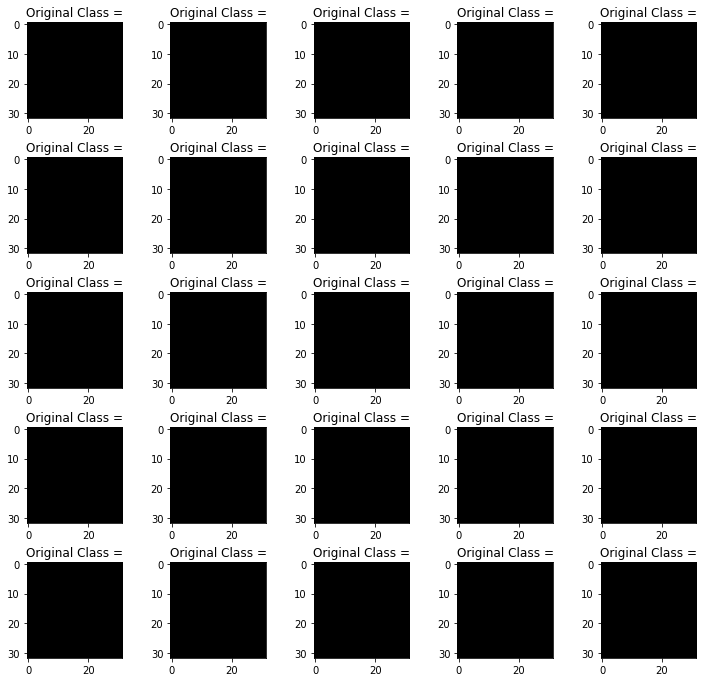

In [ ]:
L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = ") 
    axes[i].set_title("Original Class =" )
plt.subplots_adjust(wspace=0.5)

# **Comparandos os modelos**

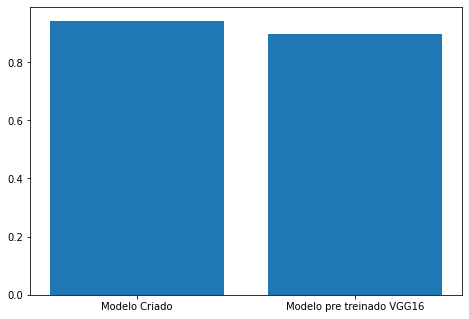

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()